# Project: A/B Test on E-commerce Website

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Conclusion](#conclusion)

<a id='intro'></a>
## Introduction

The aim of this project is to determine if the new website design will lead to more convertions. To achive this, it is important to understand the outcomes of an A/B test run on the e-ecommerce website.

<a id='probability'></a>
## Part I - Probability

`1.` First, the necessary packages need to be imported. Random seed of 42 is set to ensure reproducible code.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from scipy.stats import norm
import time

random.seed(42)

`2.` Data collection

In [3]:
name_file = 'ab_data.csv'
ab_df = pd.read_csv(name_file)
ab_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`3.` We need to observe the number of rows and the data types of each column. The `user_id` column should be converted to string and the `timestamp` column should be converted to datetime. We also observe there is no missing values.

In [4]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df = ab_df
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['user_id'] = df['user_id'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  object        
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.2+ MB


`4.` Finding the number of rows

In [6]:
num_rows = df.shape[0]
num_rows

294478

`5.` Finding the number of unique users 

In [7]:
num_unique_user = df.user_id.nunique()
num_unique_user

290584

`6.` Checking that the control group landed on the old page and that the treatment group landed to the new page.

In [8]:
#(bool) == (bool) -> (True) == (True) will lead to True & (False) == (False) will lead to True.

df2 = df[(df.group == 'control') == (df.landing_page == 'old_page')]
df2.shape

(290585, 5)

In [9]:
#checking
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`7.` Dropping duplicates on the `user_id` column.

In [10]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')
df2.shape

(290584, 5)

`8.` What is the probability of a person to convert regardless of the landing page given?

In [11]:
prob_converted = np.mean(df2.converted)
prob_converted

0.11959708724499628

`9.` What is the probability of a peson to convert given that they are in the control group?

In [12]:
prob_converted_control = np.mean(df2[df2.group == 'control'].converted)
prob_converted_control

0.1203863045004612

`10.` What is the probability of a peson to convert given that they are in the treatment group?

In [13]:
prob_converted_treatment = np.mean(df2[df2.group == 'treatment'].converted)
prob_converted_treatment

0.11880806551510564

<a id='ab_test'></a>
## Part 2 - A/B Test

`1.` Setting the Null and Alternative hypothesis.

$$H_{0}: p_{new} - p_{old} \leq 0$$
$$H_{1}: p_{new} - p_{old} > 0$$

`2.` Run 10,000 times the experiment using bootstraping. Here we do not assume that number of people in the control group and test group remain constant. 

**Note:** It is fair to mention that there is a time stamp associated with each event, therefore it is hard to know when the experiment is stopped. Do we stop it as soon as one page is considered significantly better than the other or does it have to happen consistently for a certain amount of time? These questions are the difficult parts associated with A/B tests in general. 

In [14]:
start = time.time()

differ = []

for _ in range(10000):
    
    df_sample = df2.sample(df2.shape[0], replace=True)
    treatment_array = np.array(df_sample[df_sample.group == 'treatment'].converted)
    control_array = np.array(df_sample[df_sample.group == 'control'].converted)
    treatment_convertion = np.mean(treatment_array)
    control_convertion = np.mean(control_array)
    diff = treatment_convertion - control_convertion
    differ.append(diff)
    

end = time.time()
print((end - start)/60)

45.11962834596634


In [15]:
ob_diffe = df2[df2.group == 'treatment'].converted.mean() - df2[df2.group == 'control'].converted.mean()
differ_array = np.array(differ)
null_diff = np.random.normal(0, np.std(differ, ddof=1), differ_array.size)

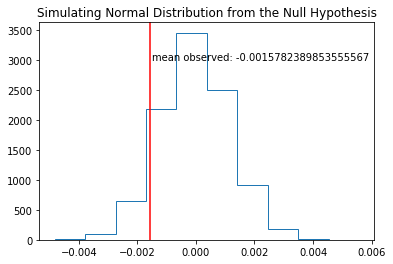

In [27]:
plt.hist(null_diff, histtype='step')
plt.axvline(ob_diffe, color='red')
plt.title('Simulating Normal Distribution from the Null Hypothesis')
plt.savefig('null_dist.png')
plt.text(-0.0015, 3000, 'mean observed: ' + str(ob_diffe));

In [19]:
#Large p_values suggest that we fail to reject the null hypothesis
p_value = np.mean(null_diff > ob_diffe) #h1 > 0 we use the sign of the alternative hypothesis
p_value

0.9085

<a id='conclusion'></a>
## Conclusion

We fail to reject the null hypothesis. Therefore staying with the old landing page is the best option.